In [1]:
import collections
import matplotlib.pyplot as plt
import getpass
import glob
import itertools
import json
import numpy as np
import os
import openml
import pandas as pd
import scipy.stats

from plot_utils.style import style_dc
from plot_utils.common_plots import rank, average_plot
from plot_utils.common_tables import collect_data_for_final_table, do_wilcoxon_test
from plot_utils.common_loading import load_from_openml

import sys
sys.path.append("/home/eggenspk/Work/Project/2020_PoSH_Autosklearn/2020_IEEE_Autosklearn_experiments/experiment_scripts/")
sys.path.append("/home/feurerm/sync_dir/projects/2020_posh/2020_IEEE_Autosklearn_experiments/experiment_scripts")
from utils import openml_automl_benchmark, automl_test_benchmark, get_normalization_constants

In [2]:
COLORS = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
FONTSIZE = 20

In [3]:
username = getpass.getuser()
dir_ = {
    'eggenspk': "/home/eggenspk/Work/data/ASKL_20/",
    'feurerm': "/home/feurerm/projects/2021_posh_new/",
}[username]
valid_pretty = {
    #1: {
    #(True, "1MIN/RQ1_AutoAuto_simulate/dynamic/"): "With Portfolio (dynamic)",
    #(True, "1MIN/RQ1_AutoAuto_simulate/static/"): "With Portfolio (static)",
    #(True, "1MIN/RQ2.2_AutoAuto_simulate/dynamic/"): "Without Portfolio (dynamic)",
    #(True, "1MIN/RQ2.2_AutoAuto_simulate/static/"): "Without Portfolio (static)",
    #},
    10: {
    (True, "10MIN/RQ1_AutoAuto_simulate/dynamic/"): "With Portfolio (dynamic)",
    (True, "10MIN/RQ1_AutoAuto_simulate/static/"): "With Portfolio (static)",
    (True, "10MIN/RQ2.2_AutoAuto_simulate/dynamic/"): "Without Portfolio (dynamic)",
    (True, "10MIN/RQ2.2_AutoAuto_simulate/static/"): "Without Portfolio (static)",
    },
    60: {
    (True, "60MIN/RQ1_AutoAuto_simulate/dynamic/"): "With Portfolio (dynamic)",
    (True, "60MIN/RQ1_AutoAuto_simulate/static/"): "With Portfolio (static)",
    (True, "60MIN/RQ2.2_AutoAuto_simulate/dynamic/"): "Without Portfolio (dynamic)",
    (True, "60MIN/RQ2.2_AutoAuto_simulate/static/"): "Without Portfolio (static)",
    },
}

task_ids = openml_automl_benchmark
n_seeds = 10
#task_ids = automl_test_benchmark
#n_seeds = 3

res_dc = {}
miss = 0
fallback = 0
for horizon in list(valid_pretty.keys()):
    res_dc[horizon] = {}
    for tid in task_ids:
        res_dc[horizon][tid] = {}
        for mode in list(valid_pretty[horizon].keys()):
            res_dc[horizon][tid][mode] = []
            for seed in range(n_seeds):
                if not mode[0]:
                    fl_tmpl = dir_ + mode[1] + "autoauto_%d_%d/ensemble_results_bac_%d_%d_0.000000thresh_50size_1.000000best_only_portfolio.json" % (tid, seed, tid, seed)
                else:
                    fl_tmpl = dir_ + mode[1] + "autoauto_%d_%d/ensemble_results_bac_%d_%d_0.000000thresh_50size_1.000000best.json" % (tid, seed, tid, seed)
                fl = glob.glob(fl_tmpl)               
                if len(fl) == 0:
                    fl_tmpl = dir_ + mode[1] + "autoauto_%d_%d/result.json" % (tid, seed)
                    fl = glob.glob(fl_tmpl)
                    if len(fl) == 0:
                        miss += 1
                        print(fl_tmpl)
                        continue
                    else:
                        fallback += 1
                        print('Ensemble missing, falling back to regular', fl[0])
                        pass
                fl = fl[0]
                with open(fl, "r") as fh:
                    line = json.load(fh)
                    if "50" in line:
                        loss = line["50"]["trajectory"]
                    else:
                        loss = line["0"]["trajectory"]
                    loss = [(l[0], l[1]) for l in loss]
                    loss = dict(loss)
                    res_dc[horizon][tid][mode].append(loss)
print("Missing %d entries" % miss)

# There should be 7 fallbacks. These are all due to the statict strategy being 3-fold CV, which does
# not work for the dionis dataset
print("Fallback %d entries" % fallback)

Missing 0 entries
Fallback 0 entries


In [4]:
# Load some stuff from disc and openml - takes some time
tasks, task_ids_sorted_by_num_features = load_from_openml(task_ids)
min_diff_dc, _, _, _, _ = get_normalization_constants(
    results_dir=os.path.join(dir_, "60MIN/ASKL_automldata_run_with_portfolio_w_ensemble"),
    task_ids=task_ids,
    load=False,
    n_seeds=n_seeds,
)
tasks

Loaded tasks from openml
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_None_10CV_iterative_es_if
Could not find a runhistory for task IDCould not find a runhistory for task ID 168797 168796 and model selection strategy  RF_None_10CV_iterative_es_ifand model selection strategy
 RF_None_10CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_3CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_5CV_iterative_es_if
Could not find a runhistory for task ID 189873 and model selection strategy RF_SH-eta4-i_10CV_iterative_es_if
Could not find a runhistory for task ID 168797 and model selection strategy RF_SH-eta4-i_10CV_iterative_es_if
Could not find

,tid,ttid,did,name,task_type,status,estimation_procedure,evaluation_measures,source_data,target_feature,...,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,cost_matrix
189871,189871,TaskType.SUPERVISED_CLASSIFICATION,41163,dilbert,Supervised Classification,active,33% Holdout set,NaN,41163,class,...,5.0,1913.0,5.0,2001.0,10000.0,0.0,0.0,2000.0,1.0,NaN
189872,189872,TaskType.SUPERVISED_CLASSIFICATION,41164,fabert,Supervised Classification,active,33% Holdout set,NaN,41164,class,...,7.0,502.0,7.0,801.0,8237.0,0.0,0.0,800.0,1.0,NaN
189873,189873,TaskType.SUPERVISED_CLASSIFICATION,41167,dionis,Supervised Classification,active,33% Holdout set,NaN,41167,class,...,355.0,878.0,355.0,61.0,416188.0,0.0,0.0,60.0,1.0,NaN
168794,168794,TaskType.SUPERVISED_CLASSIFICATION,41165,robert,Supervised Classification,active,33% Holdout set,predictive_accuracy,41165,class,...,10.0,958.0,10.0,7201.0,10000.0,0.0,0.0,7200.0,1.0,NaN
168792,168792,TaskType.SUPERVISED_CLASSIFICATION,41168,jannis,Supervised Classification,active,33% Holdout set,predictive_accuracy,41168,class,...,4.0,1687.0,4.0,55.0,83733.0,0.0,0.0,54.0,1.0,NaN
168793,168793,TaskType.SUPERVISED_CLASSIFICATION,41166,volkert,Supervised Classification,active,33% Holdout set,predictive_accuracy,41166,class,...,10.0,1361.0,10.0,181.0,58310.0,0.0,0.0,180.0,1.0,NaN
75105,75105,TaskType.SUPERVISED_CLASSIFICATION,1111,KDDCup09_appetency,Supervised Classification,active,33% Holdout set,predictive_accuracy,1111,APPETENCY,...,15415.0,890.0,2.0,231.0,50000.0,50000.0,8024152.0,192.0,39.0,NaN
189906,189906,TaskType.SUPERVISED_CLASSIFICATION,40984,segment,Supervised Classification,active,33% Holdout set,NaN,40984,class,...,7.0,330.0,7.0,20.0,2310.0,0.0,0.0,19.0,1.0,NaN
189909,189909,TaskType.SUPERVISED_CLASSIFICATION,41027,jungle_chess_2pcs_raw_endgame_complete,Supervised Classification,active,33% Holdout set,NaN,41027,class,...,3.0,4335.0,3.0,7.0,44819.0,0.0,0.0,6.0,1.0,NaN
189908,189908,TaskType.SUPERVISED_CLASSIFICATION,40996,Fashion-MNIST,Supervised Classification,active,33% Holdout set,NaN,40996,class,...,10.0,7000.0,10.0,785.0,70000.0,0.0,0.0,784.0,1.0,NaN


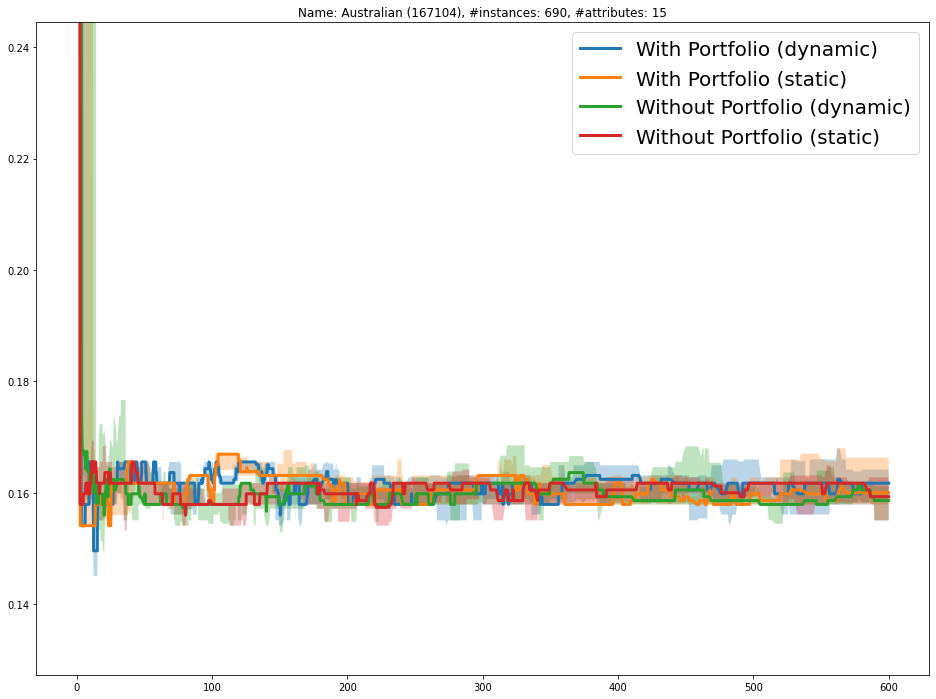

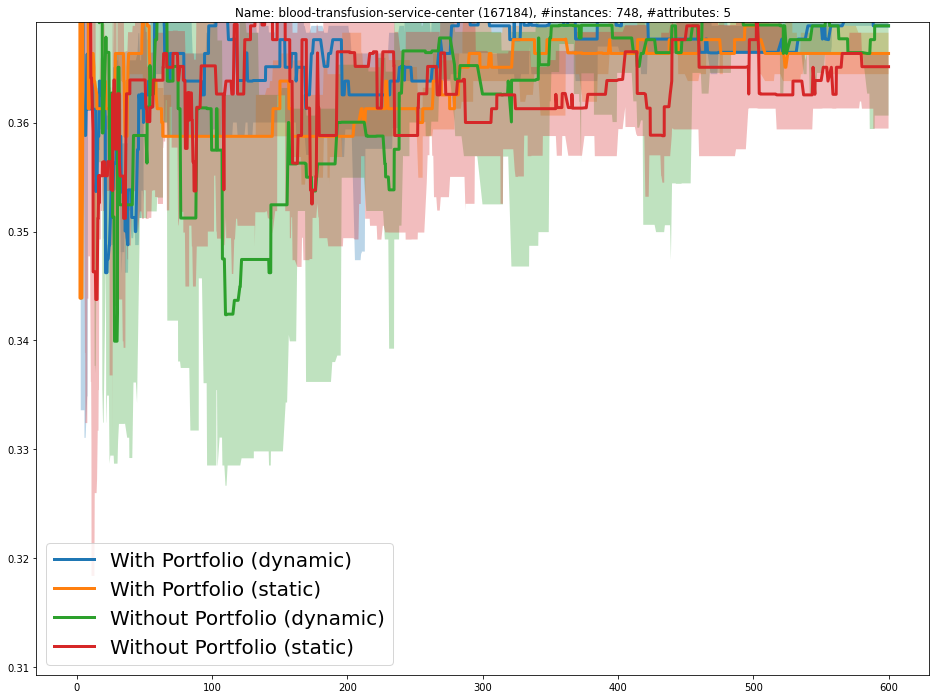

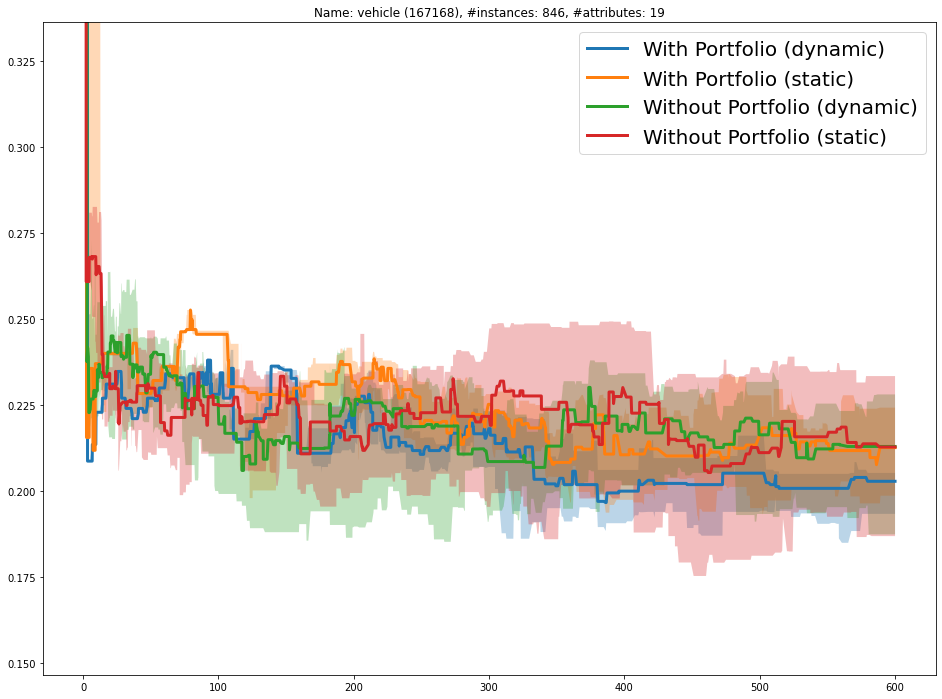

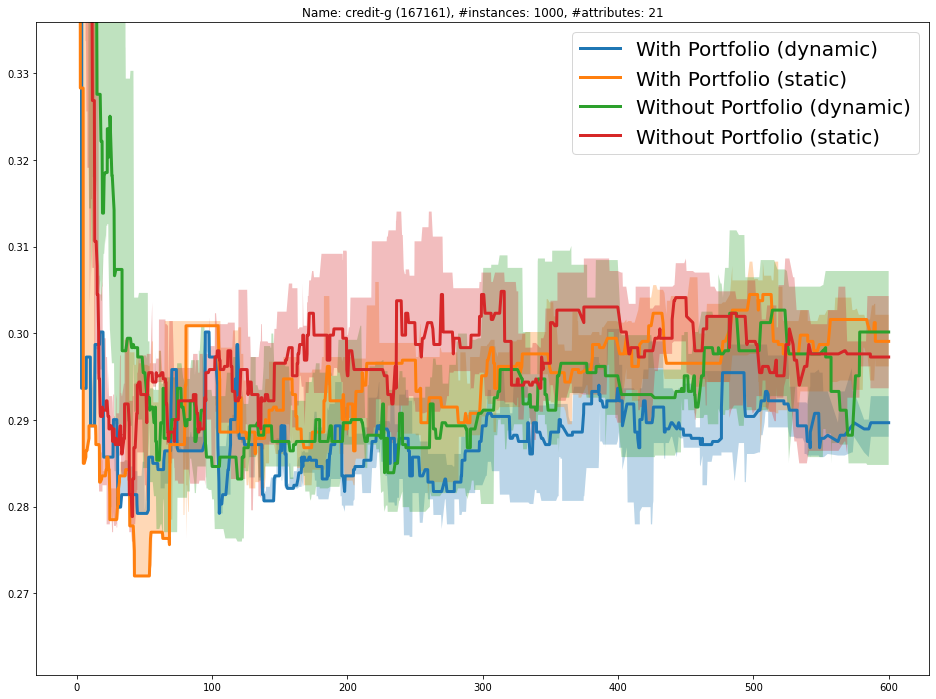

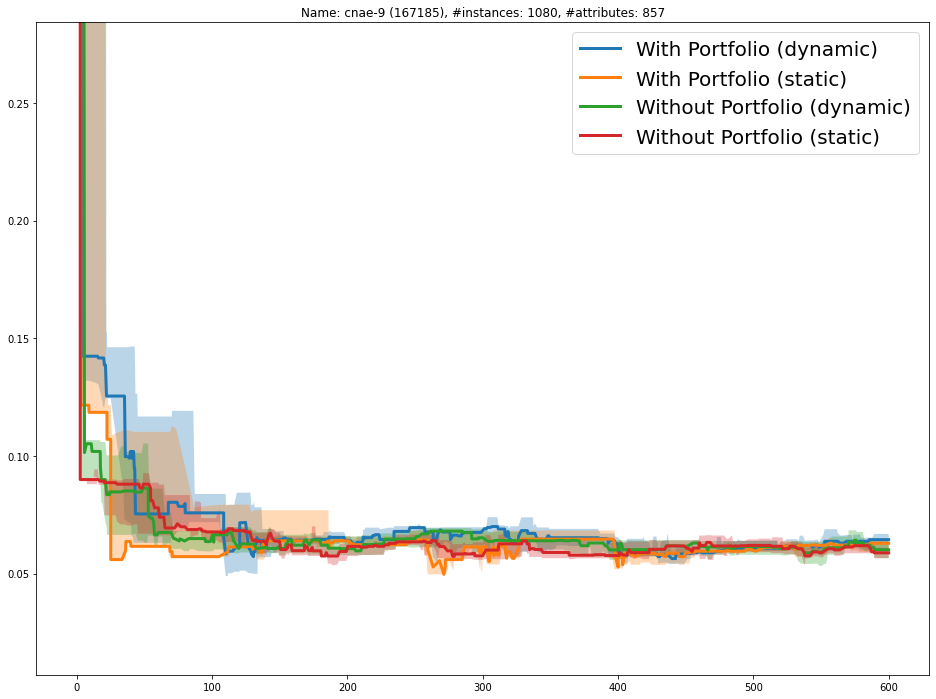

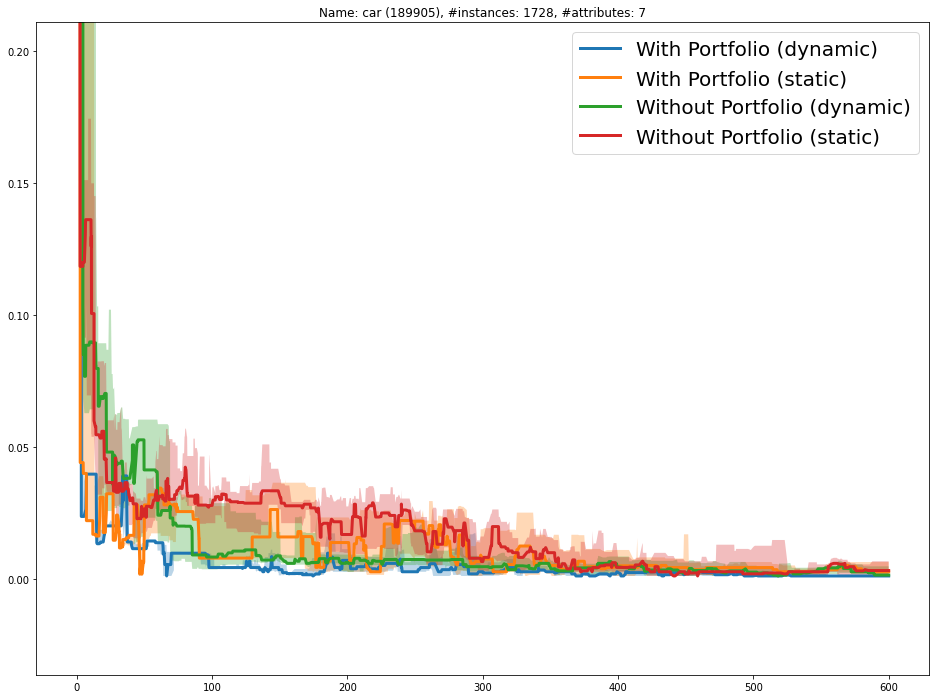

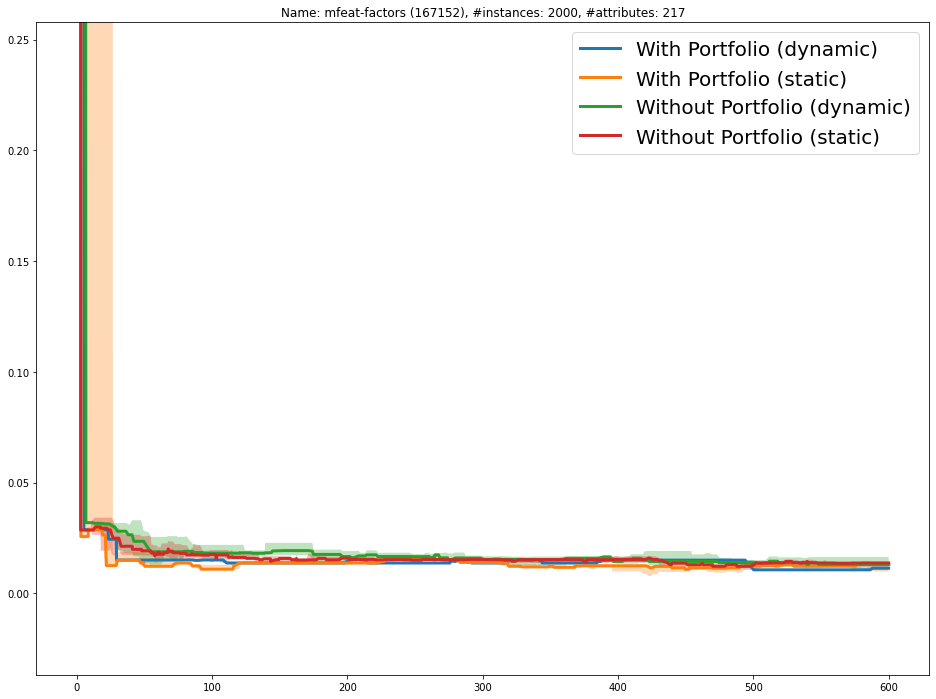

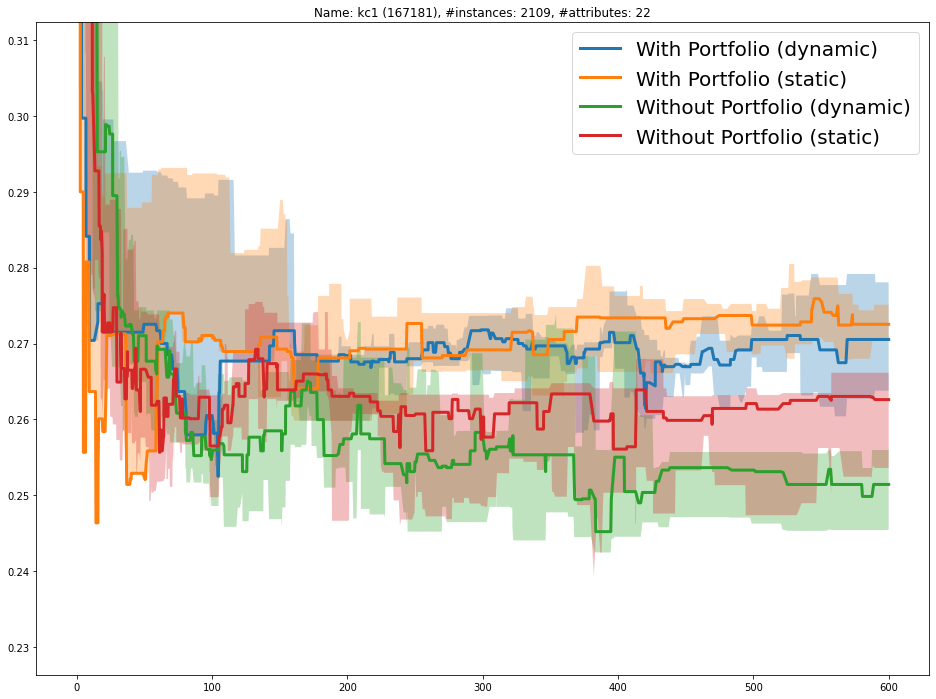

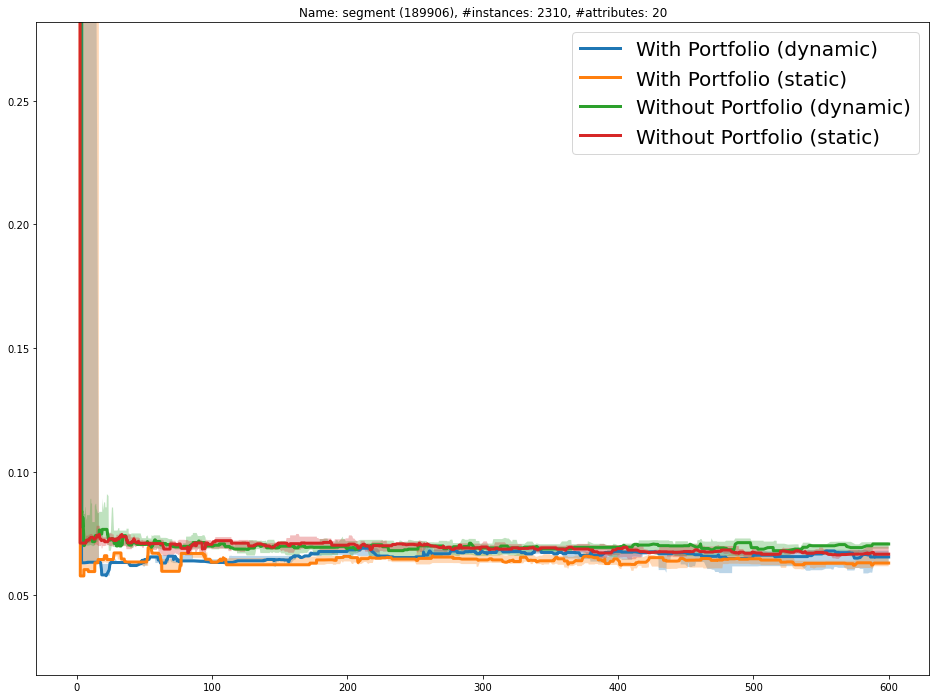

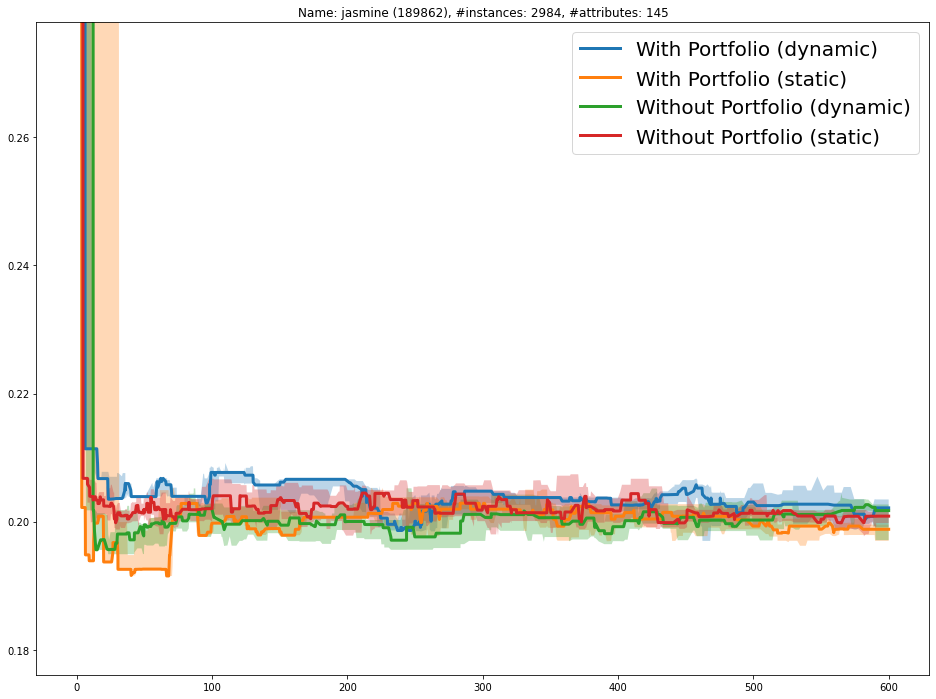

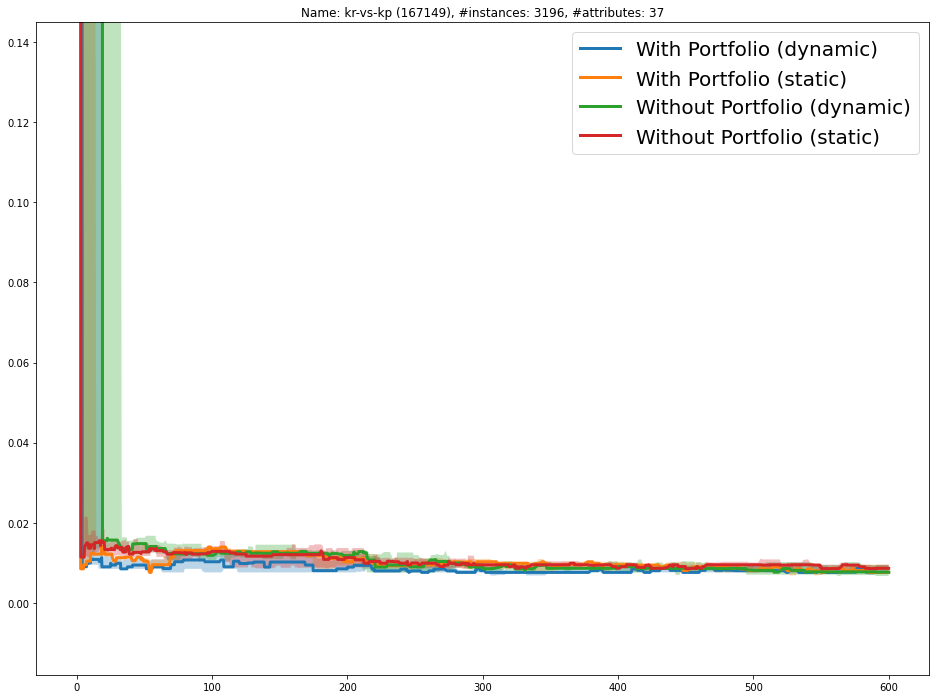

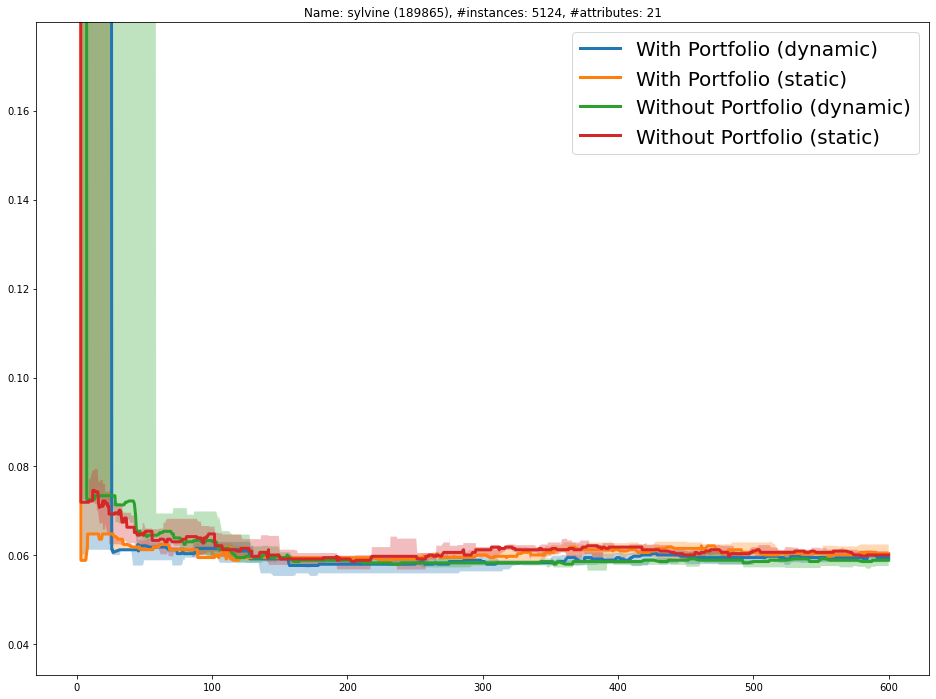

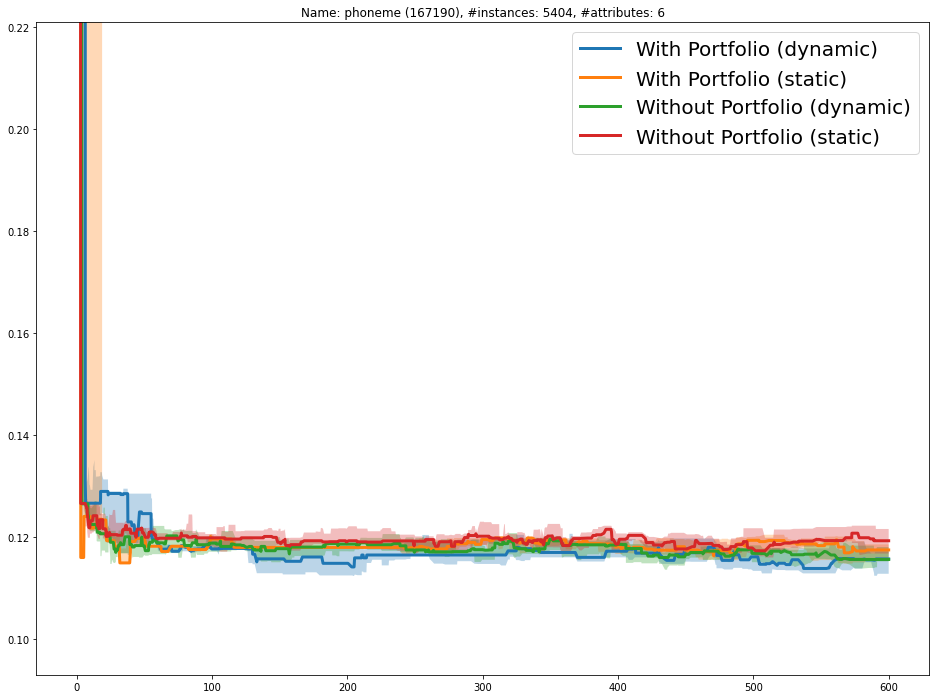

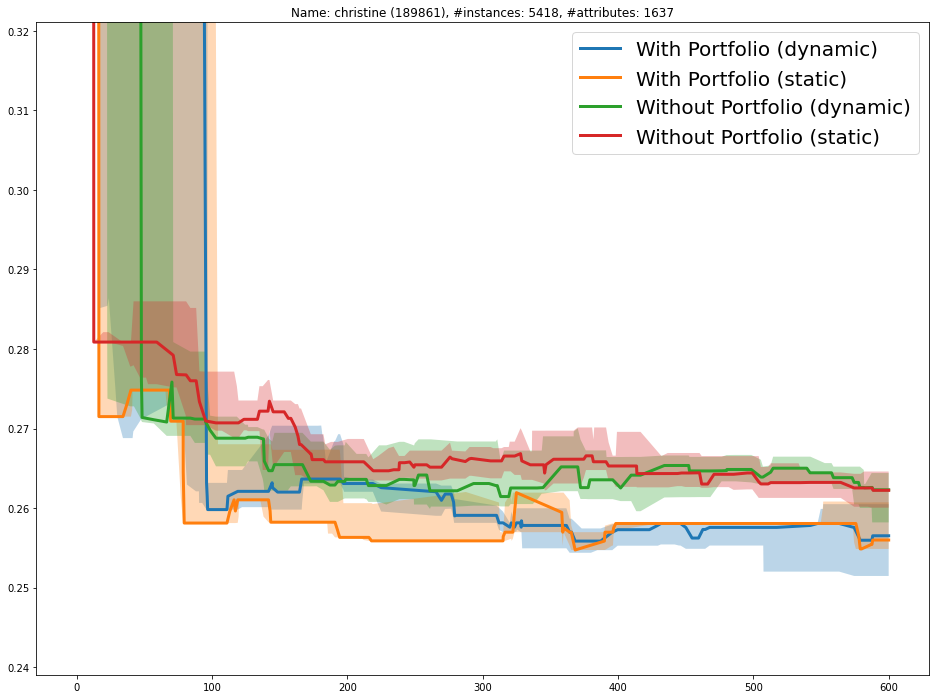

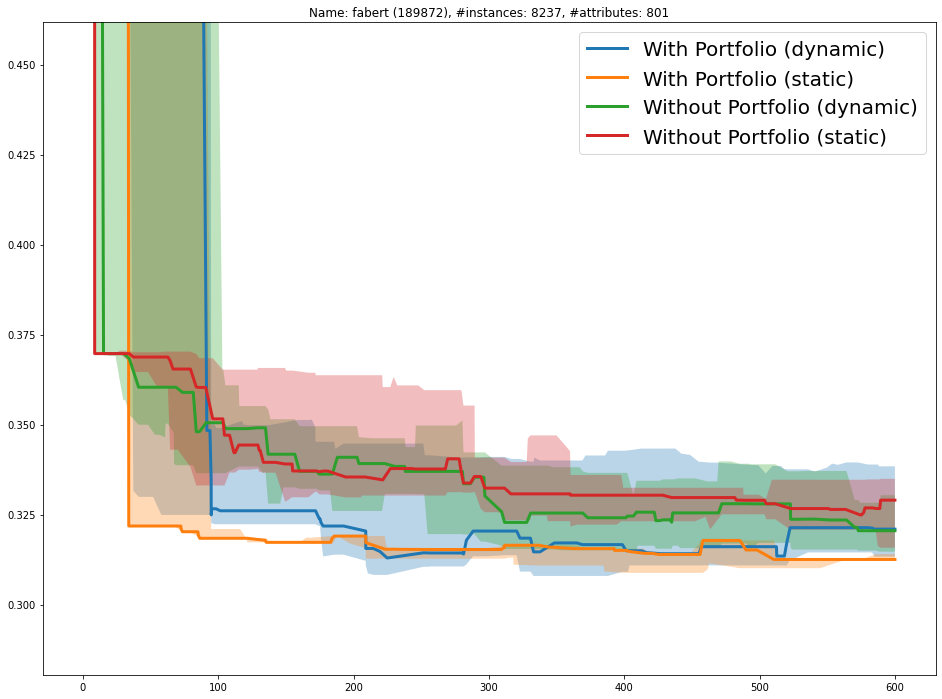

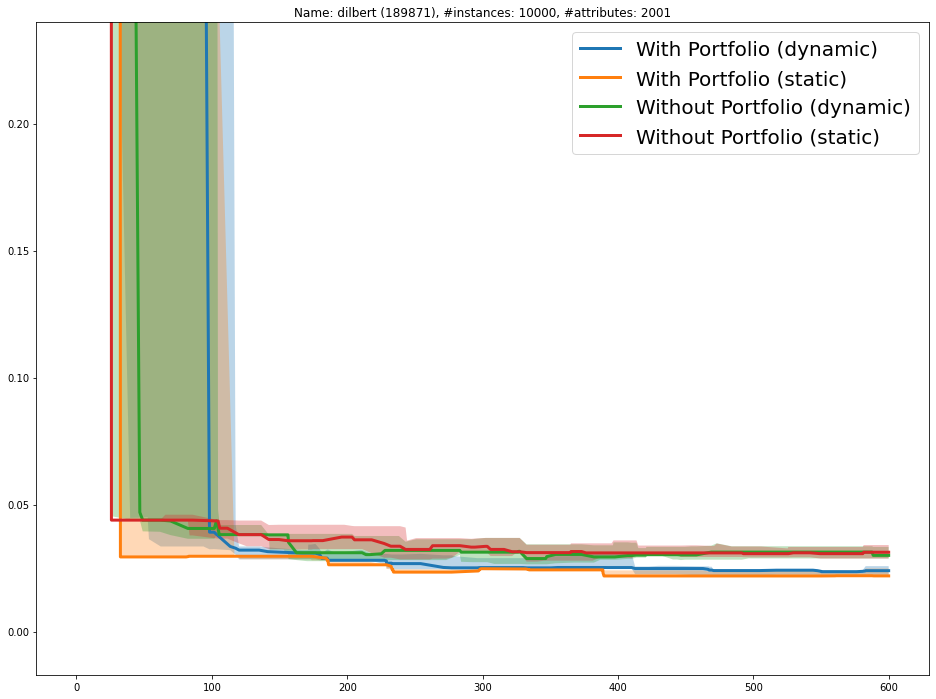

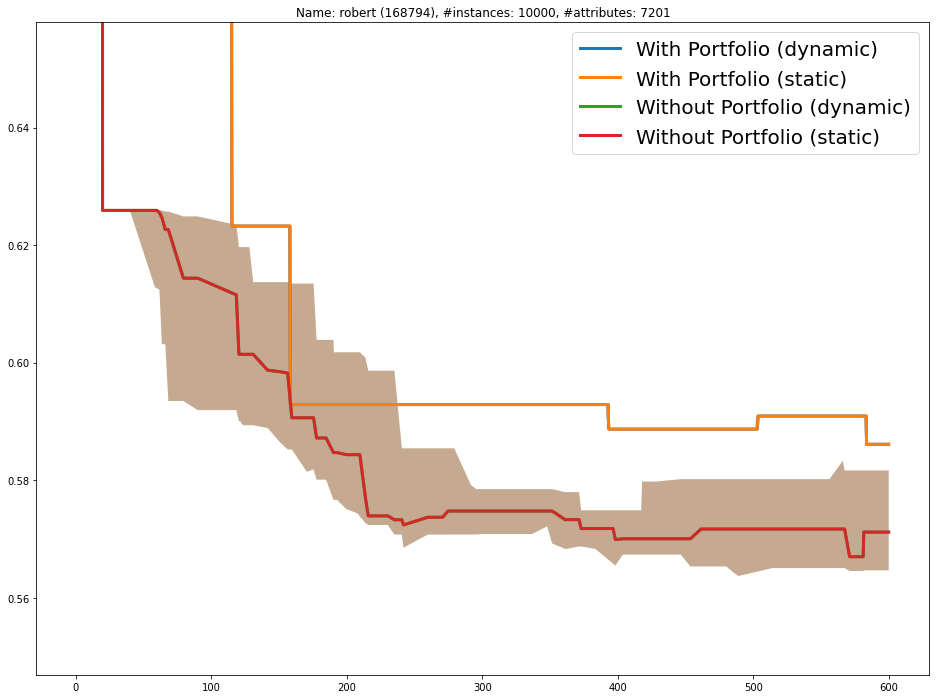

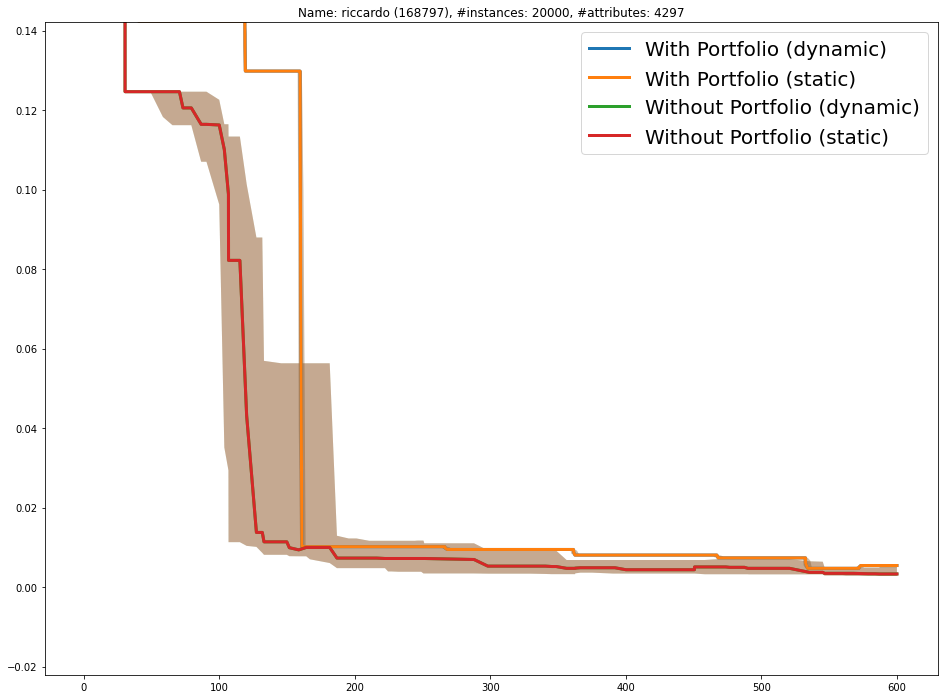

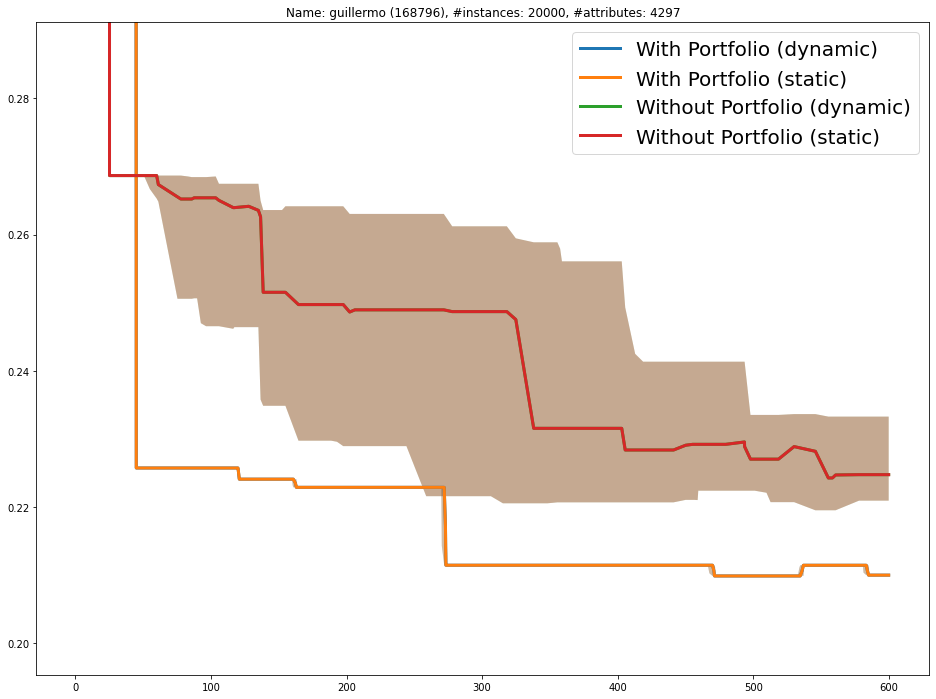

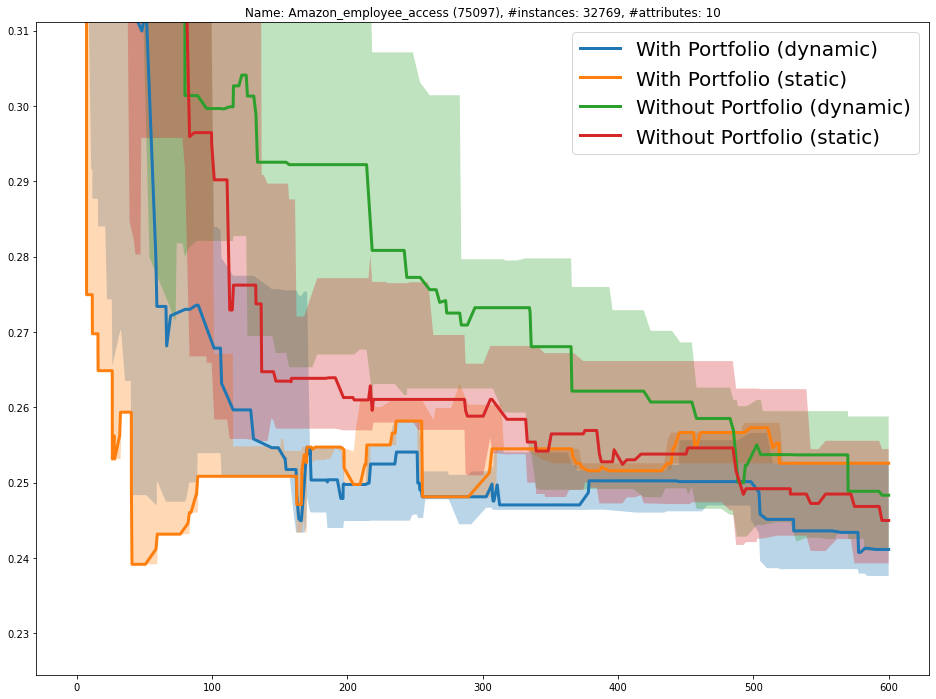

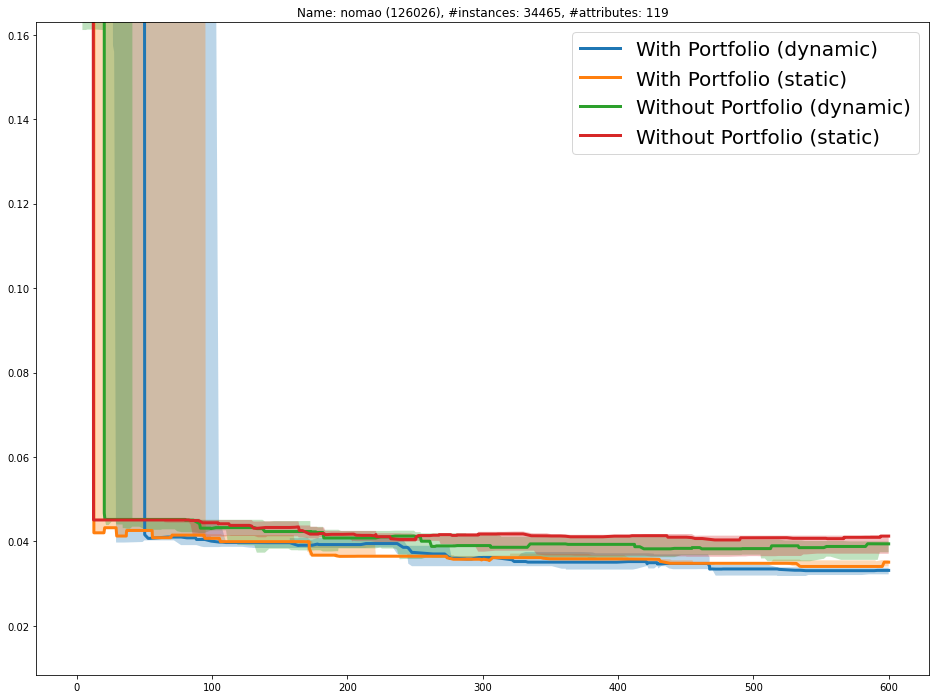

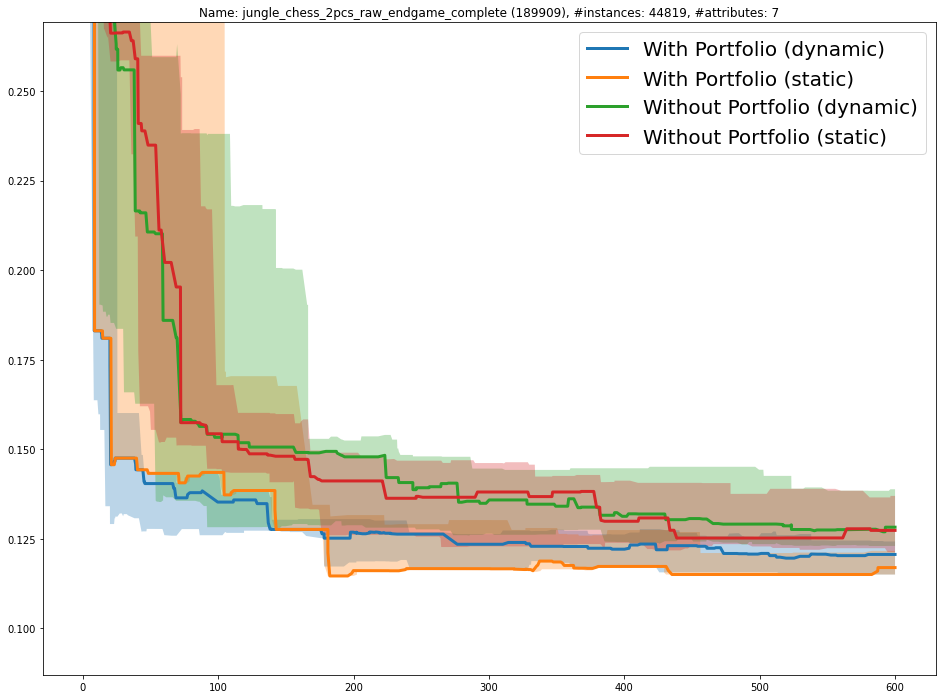

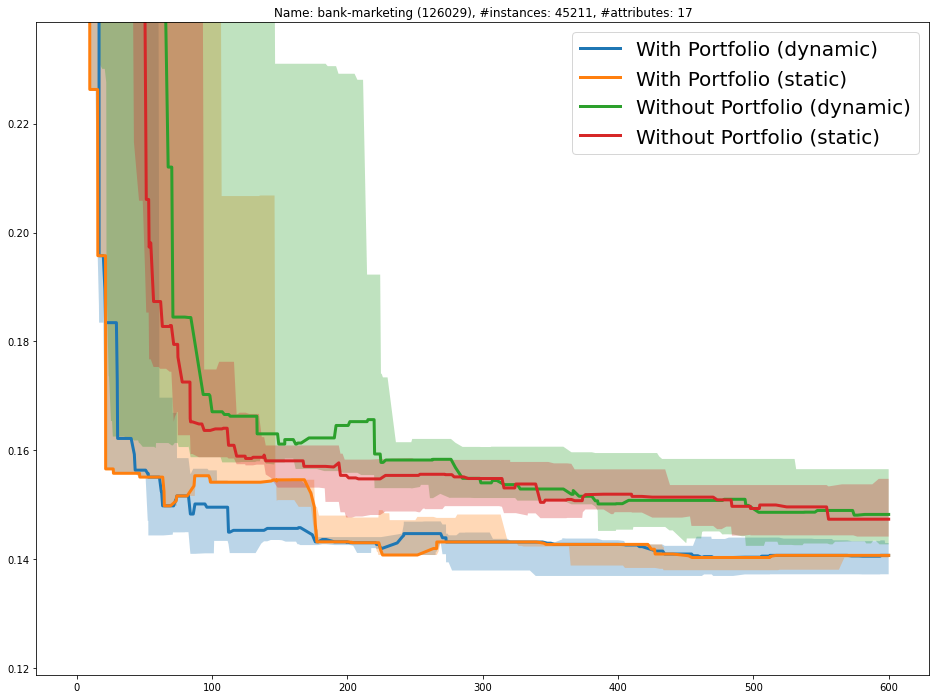

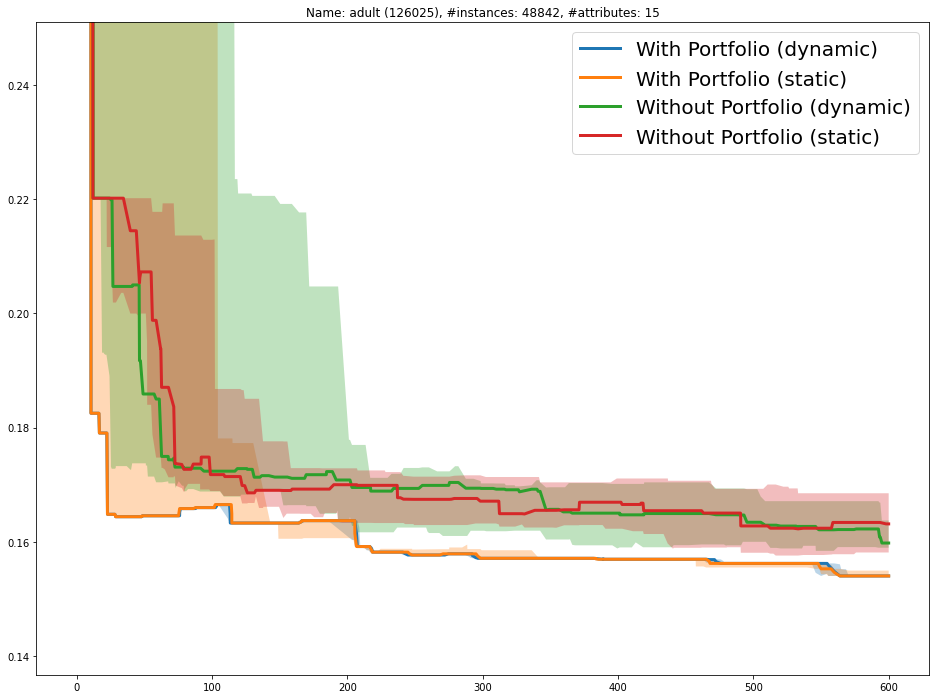

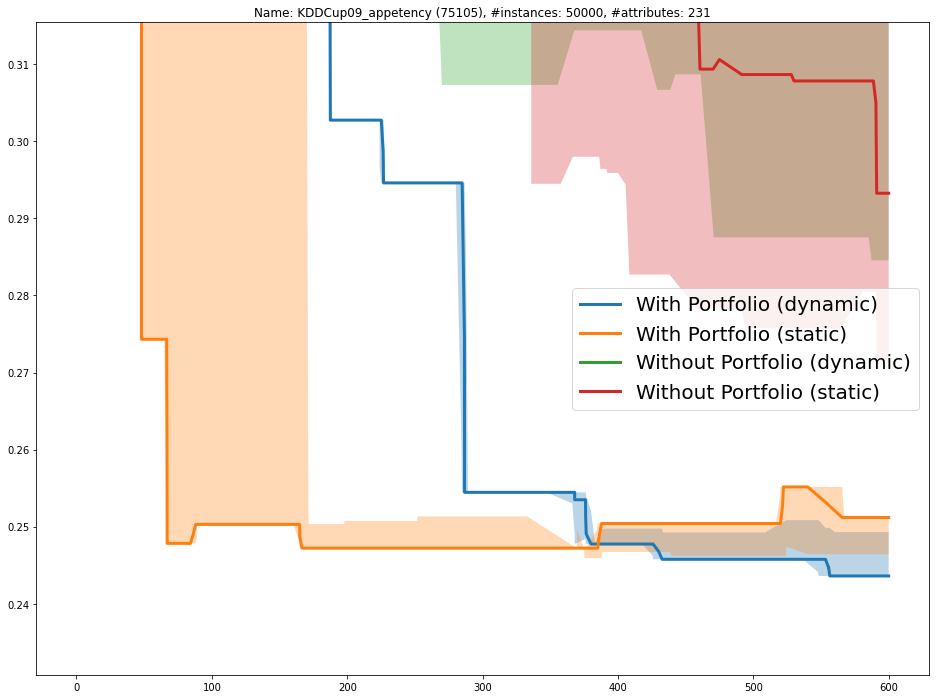

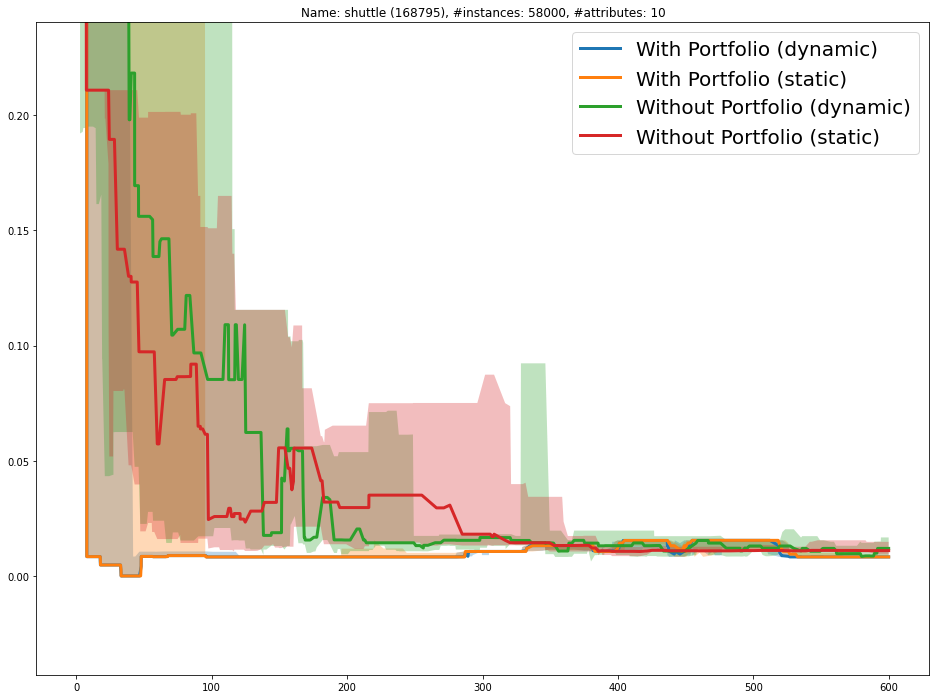

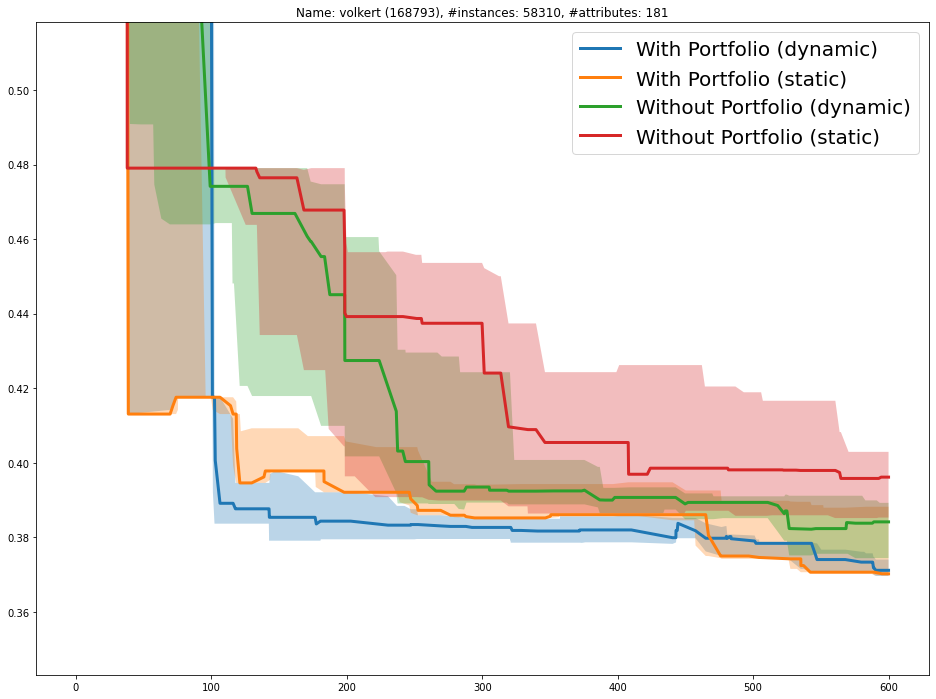

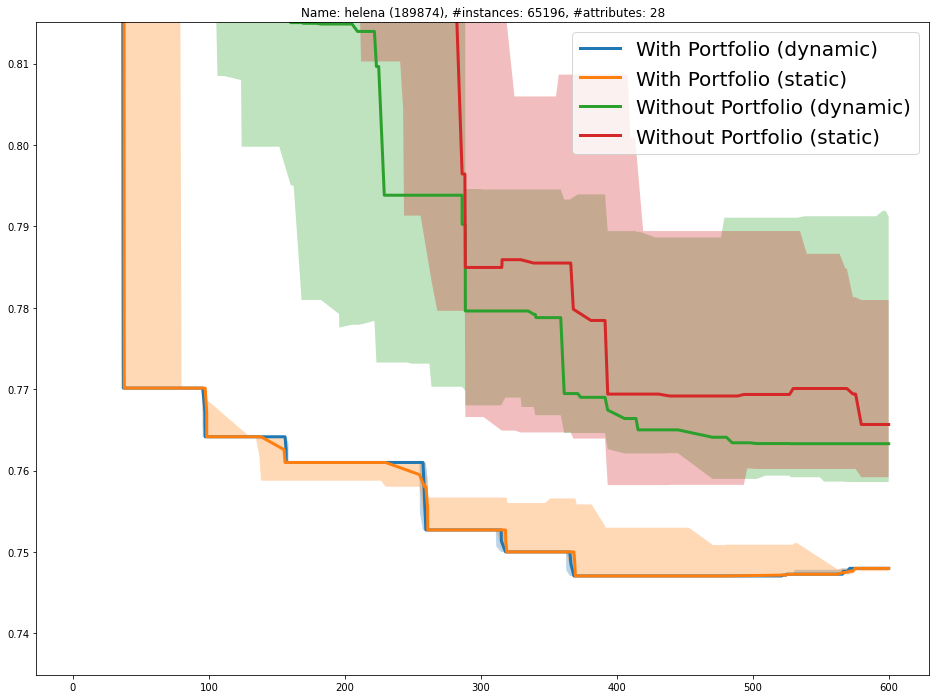

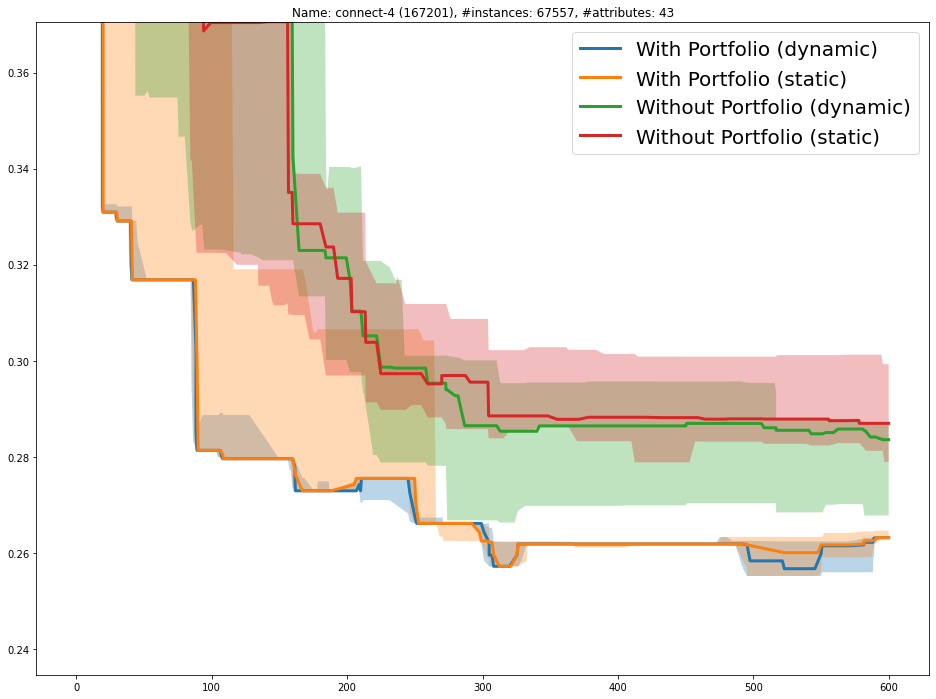

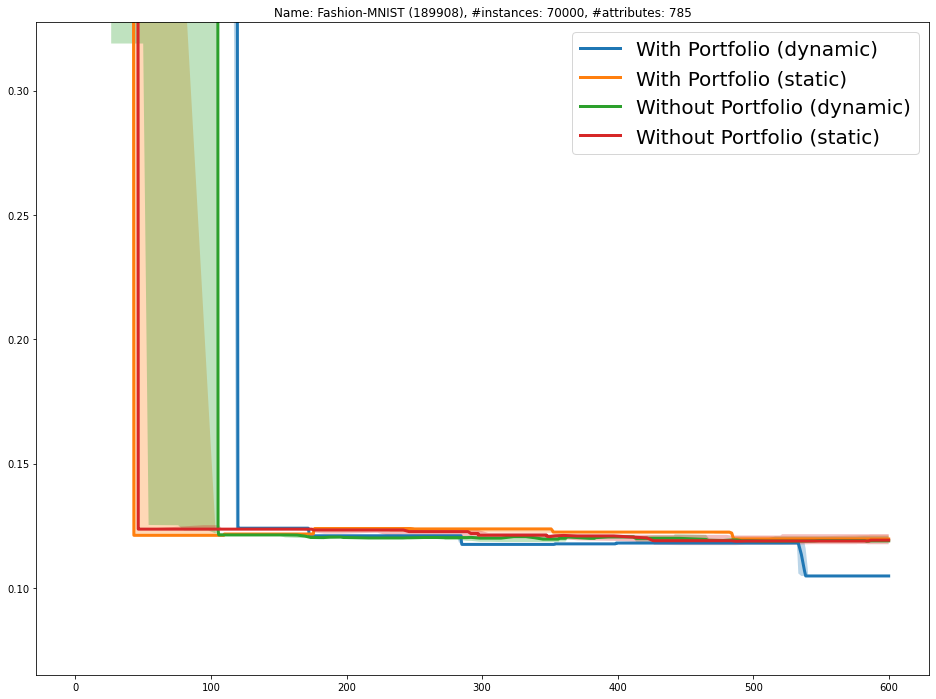

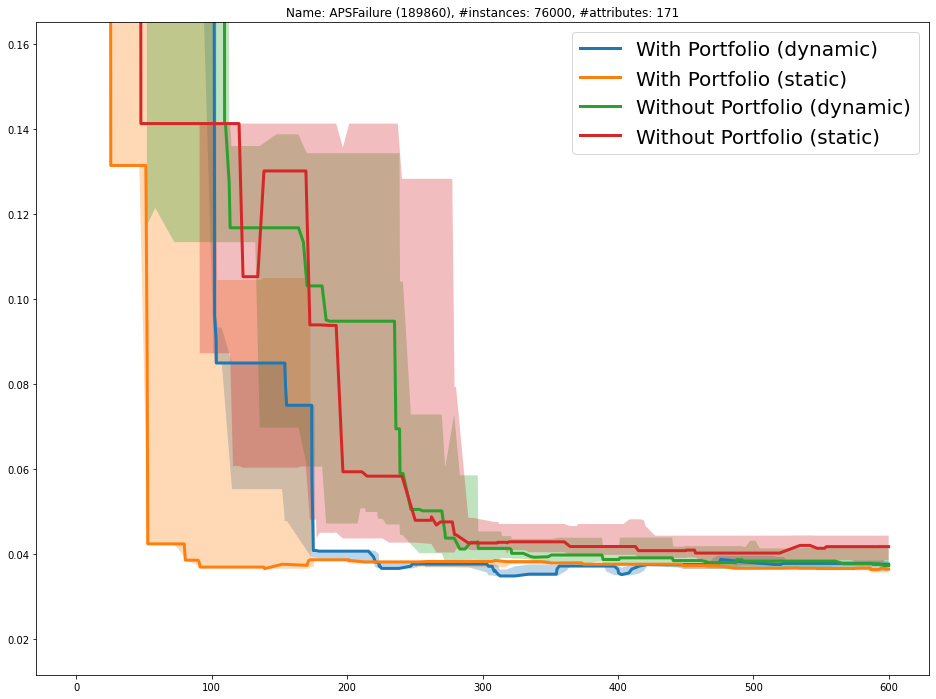

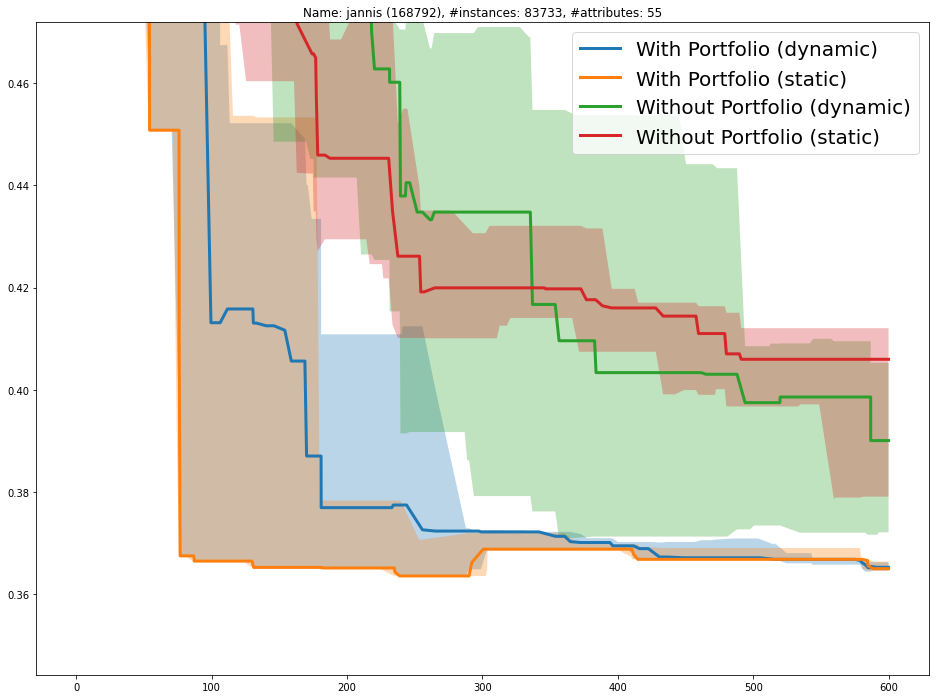

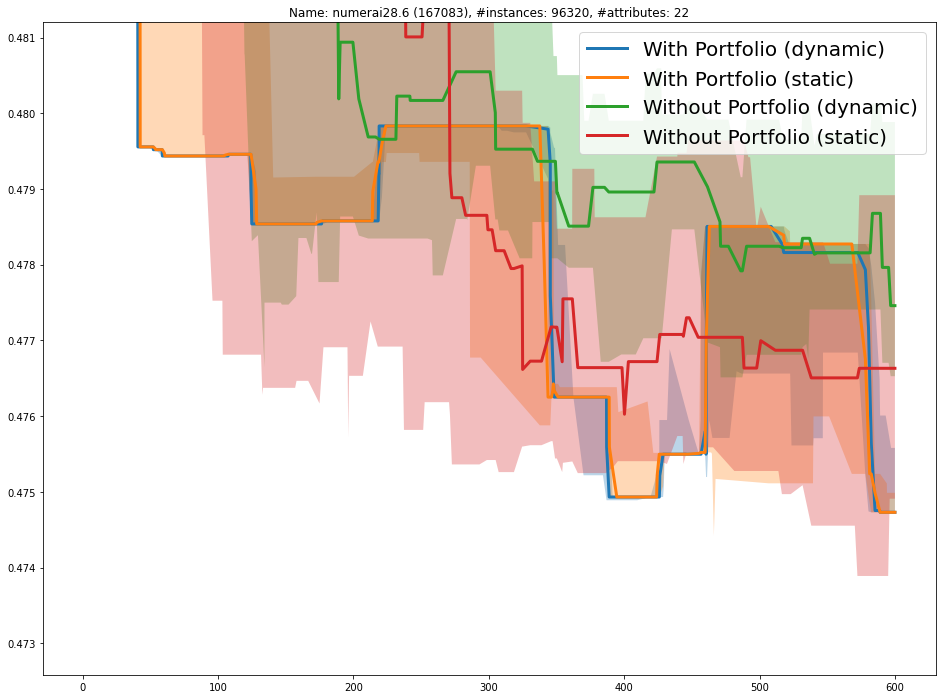

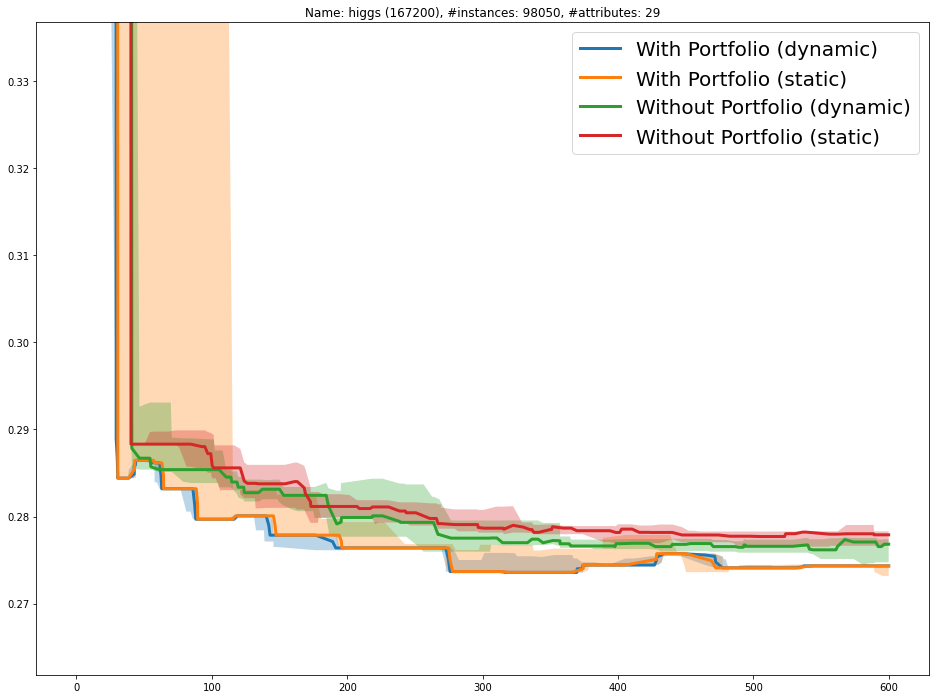

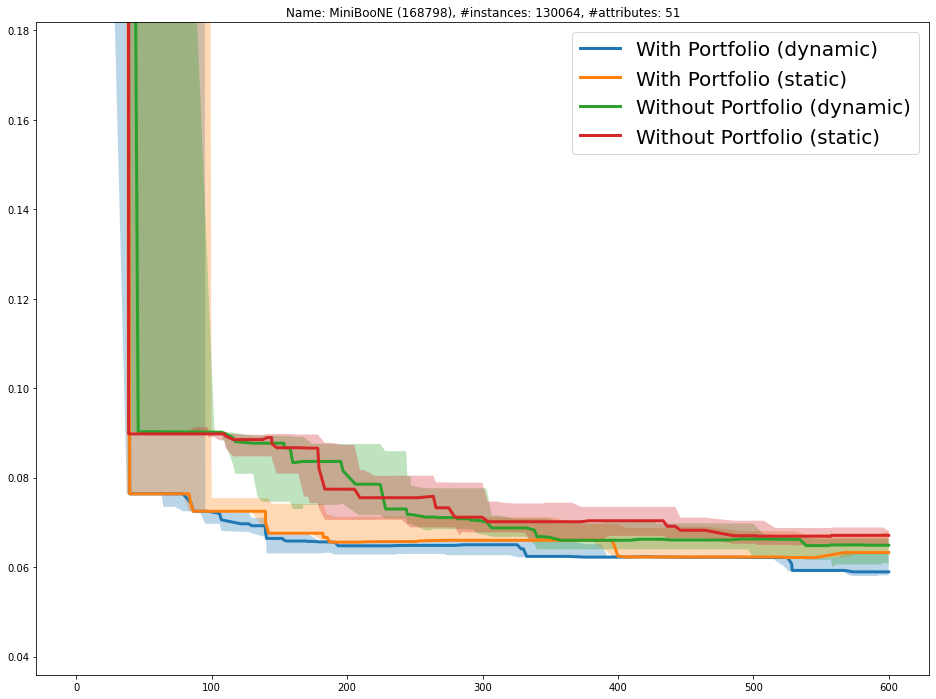

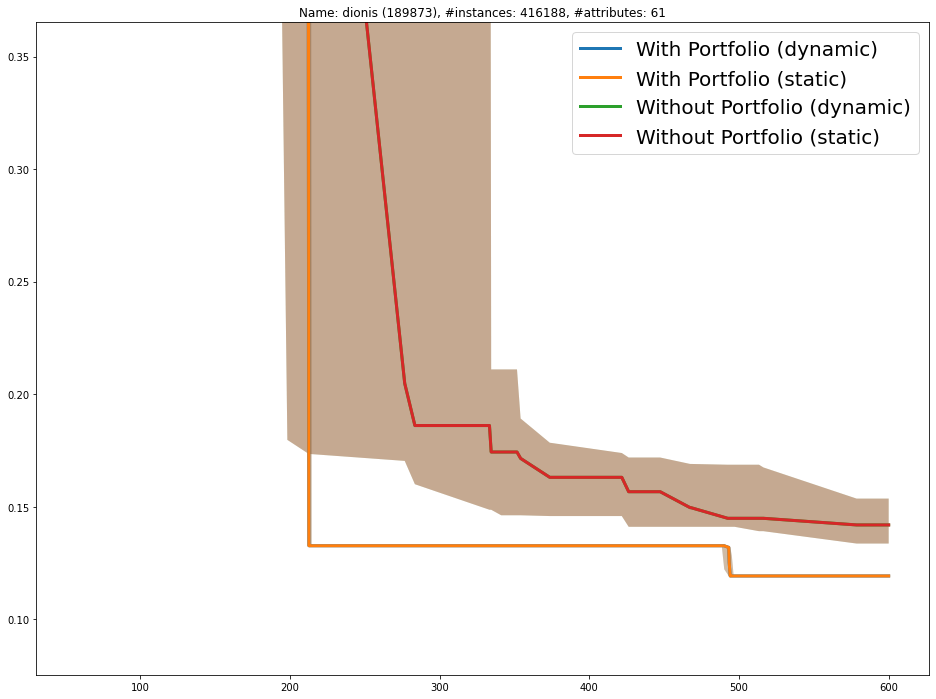

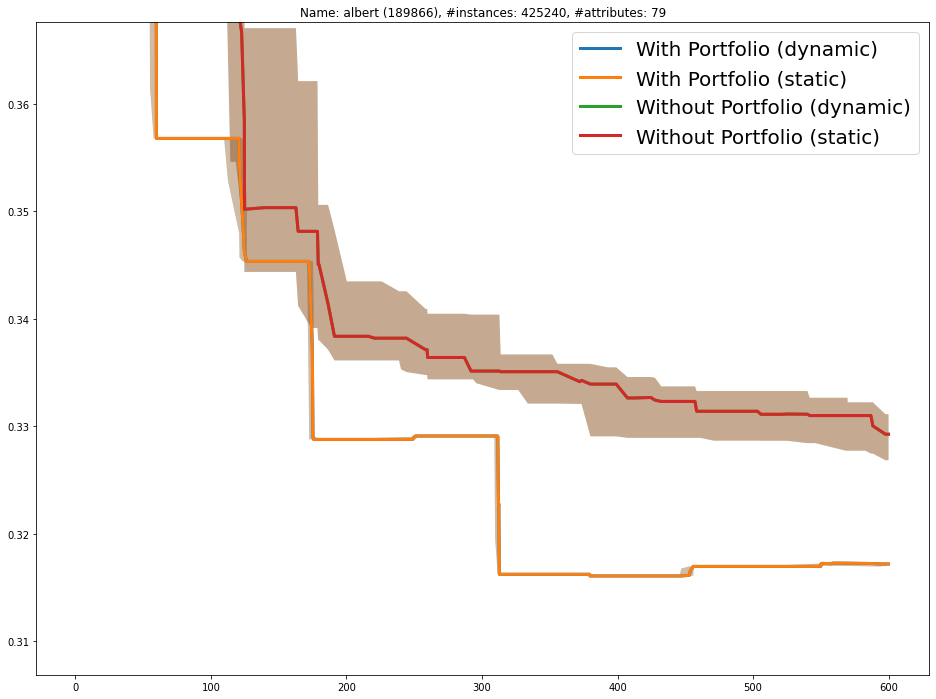

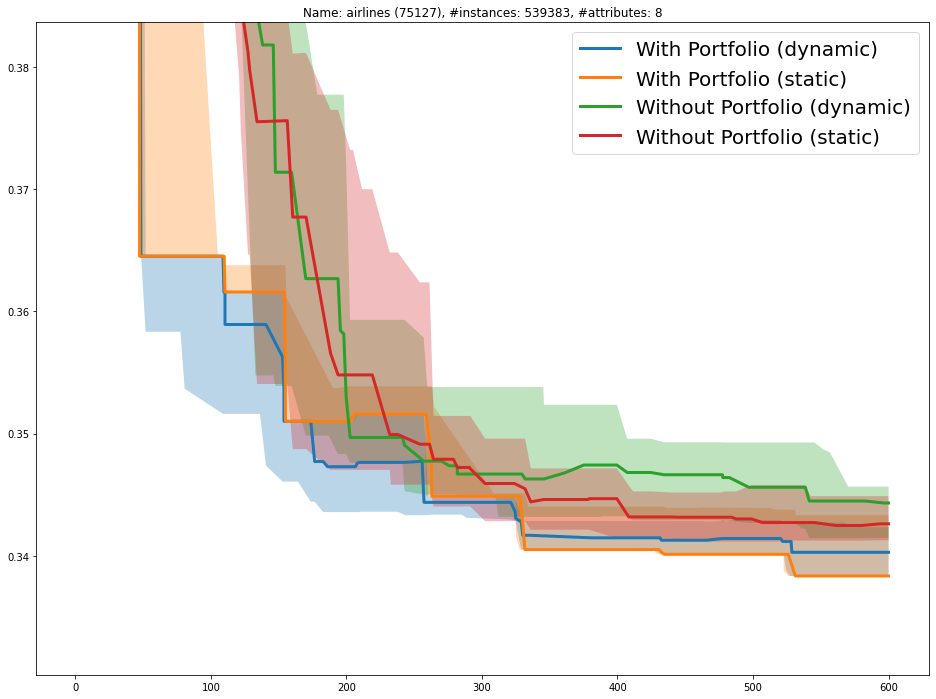

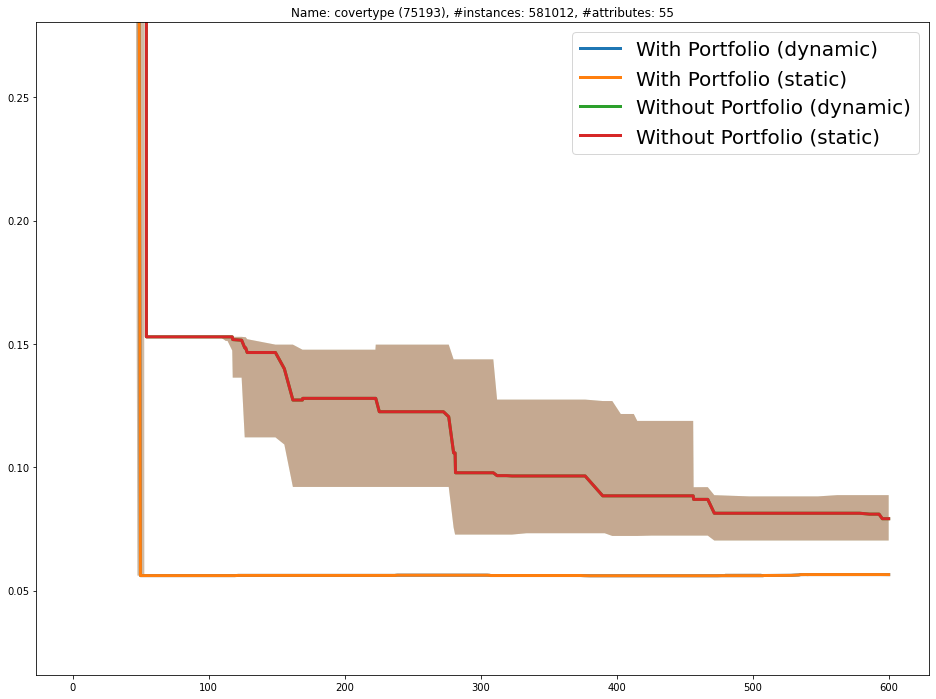

In [5]:
HORIZON = 10
for tid in task_ids_sorted_by_num_features:
    plt.figure(figsize=[16,12])
    colors = itertools.cycle(COLORS)
    for mode in list(valid_pretty[HORIZON].keys()):
        c = next(colors)
        tmp = pd.DataFrame(res_dc[HORIZON][tid][mode]).sort_index(axis=1).ffill(axis=1)
        med = tmp.median(axis=0)
        med.loc[HORIZON*60] = med.iloc[-1]
        low = tmp.quantile(0.25)
        low.loc[HORIZON*60] = low.iloc[-1]
        up = tmp.quantile(0.75, axis=0)
        up.loc[HORIZON*60] = up.iloc[-1]
        plt.plot(med.index, med.to_numpy(), label=valid_pretty[HORIZON][mode], linewidth=3)
        plt.fill_between(med.index, low, up, alpha=0.3)
    plt.title('Name: %s (%d), #instances: %d, #attributes: %d' % (
        tasks.loc[tid, 'name'], tid, tasks.loc[tid, 'NumberOfInstances'], tasks.loc[tid, 'NumberOfFeatures']))
    plt.legend(fontsize=20)
    plt.ylim([plt.ylim()[0], plt.ylim()[0] + 0.3*(plt.ylim()[1]-plt.ylim()[0])])
    #plt.yscale("log")
    plt.show()

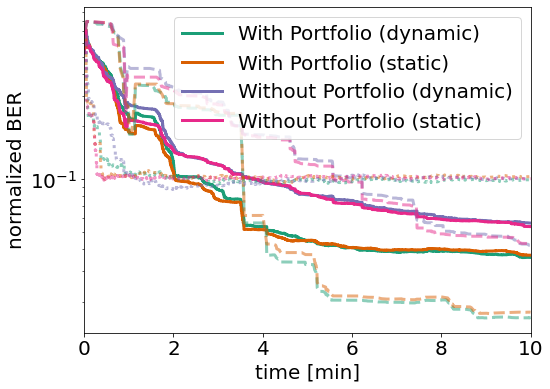

In [6]:
# Plot average BER across all datasets
HORIZON = 10
model_list = []
for m in valid_pretty[HORIZON].keys():
    model_list.append(m)

average_plot(model_list=model_list, res_dc=res_dc, valid_pretty=valid_pretty,
             horizon=HORIZON, task_ids_sorted_by_num_features=task_ids_sorted_by_num_features,
             min_diff_dc=min_diff_dc)
plt.yscale("log")
plt.show()

In [7]:
# Assume we have either all or no models
horizon_list = sorted(list(valid_pretty.keys()))
model_list = {}
for h in horizon_list:
    model_list[h] = []
    for m in valid_pretty[h].keys():
        model_list[h].append(m)

tab_data, stat_test_data = collect_data_for_final_table(
    model_list, res_dc, valid_pretty, horizon_list,
    task_ids_sorted_by_num_features, min_diff_dc, n_seeds=n_seeds,
)
not_different = do_wilcoxon_test(stat_test_data, model_list, horizon_list, valid_pretty, exclude=["Oracle",])

Not different with 10 mins:
	 With Portfolio (dynamic) vs With Portfolio (static): 0.245754
Not different with 60 mins:
	 With Portfolio (static) vs With Portfolio (dynamic): 0.85205


In [8]:
df = pd.DataFrame(tab_data)
#for horizon in horizon_list:
#    df['Rank_%s' % horizon] = df[horizon].rank(method='average', ascending=True)
print(df)
print(df.to_latex())
print(not_different)

                               10  STD 10    60  STD 60
With Portfolio (dynamic)     3.58    0.23  2.47    0.18
With Portfolio (static)      3.69    0.14  2.44    0.12
Without Portfolio (dynamic)  5.63    0.89  3.42    0.32
Without Portfolio (static)   5.37    0.58  3.61    0.61
\begin{tabular}{lrrrr}
\toprule
{} &    10 &  STD 10 &    60 &  STD 60 \\
\midrule
With Portfolio (dynamic)    &  3.58 &    0.23 &  2.47 &    0.18 \\
With Portfolio (static)     &  3.69 &    0.14 &  2.44 &    0.12 \\
Without Portfolio (dynamic) &  5.63 &    0.89 &  3.42 &    0.32 \\
Without Portfolio (static)  &  5.37 &    0.58 &  3.61 &    0.61 \\
\bottomrule
\end{tabular}

{10: [('With Portfolio (dynamic)', 'With Portfolio (static)', 0.24575428163236507)], 60: [('With Portfolio (static)', 'With Portfolio (dynamic)', 0.8520504396617044)]}


Plotting 4 models
0 / 200
50 / 200
100 / 200
150 / 200


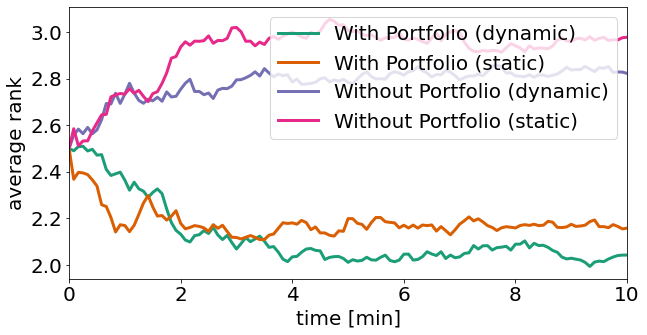

In [9]:
HORIZON = 10
model_list = []
for m in valid_pretty[HORIZON].keys():
    model_list.append(m)
rank(model_list, res_dc, valid_pretty, HORIZON, task_ids_sorted_by_num_features, n_iter=200, steplength=5)
plt.legend(fontsize=style_dc["fontsize"], loc="upper right")